# [GD10] Transformer로 번역기 만들기

# 10-1. 들어가며
나름대로 혁신적이었던 Sequence-to-Sequence 구조로 번역기를 만들었으나 성능이 기대에 미치지 않아 실망하신 분도 계신가요? 예문 한두 개 빼고는 거의 다 이상한 번역문만 나와서 슬펐던 기억이 있으시더라도...😢 하지만 이번엔 다를 거예요!

트랜스포머는 현재까지도 각종 번역 부문에서 최고의 성능을 자랑하는 모델이니 이번에야말로 정말 멋진 번역기를 만들어 보실 수 있을 거예요. 게다가 이전 강의 노드에서 배웠던 신선한 개념들이 어떻게 구현이 될지 궁금하지 않나요? 트랜스포머의 구조는 NLP 분야 최신 모델의 근간이 되기 때문에, 오늘 실습을 통해 트랜스포머의 구조를 꼼꼼히 파악해 봅시다.

## 준비물
터미널을 열고 프로젝트를 위한 디렉토리를 생성해 주세요.

```
$ mkdir -p ~/aiffel/transformer
```

실습에서는 한국어가 포함된 말뭉치를 사용하므로, 한국어를 잘 시각화하기 위한 준비가 필요합니다. 다만 matplotlib 라이브러리의 기본 폰트는 한국어를 지원하지 않아요! 올바른 Attention Map을 확인하기 위해 한국어를 지원하는 폰트로 변경해 주도록 합시다.

아래 코드를 실행합니다. 앞으로 필요하신 경우 한글을 실행해야 할 때 미리 한 번씩 실행해 주시면 됩니다.

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

%config InlineBackend.figure_format = 'retina'
 
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

print("슝=3")

슝=3


# 10-2. 내부 모듈 구현하기
이번 코스는 트랜스포머를 완성하는 데에 필요한 모듈들을 하나하나 만든 후, 조립하여 완성하는 방식으로 진행할 겁니다.

자, Tensor로 변환한 입력 데이터가 주어졌다고 가정하고 흐름을 생각해 봅시다. 최초의 텍스트 입력 데이터는 \[ batch_size x length \] 의 형태를 가지고 있겠죠? 번역이 끝나고 난 최종 출력 데이터는 [ batch_size x length x vocab_size ]의 형태를 가지게 됩니다. 번역 문제는 결국 매 스텝마다 vocab_size 만큼의 클래스 개수 중에 적당한 단어를 선택하는 작업을 length만큼 반복하는 것이니까요. 모델 구성하는 과정에서 레이어를 통과할 때마다 텐서의 shape가 어떻게 바뀌는지를 눈여겨봅시다.

1. 입력 데이터 → [ batch_size x length ]
2. Source & Target Embedding → [ batch_size x length x d_emb ]
3. Positional Encoding 강의 노드에서 구현을 했었죠? 2번의 결과에 더해지므로 shape 변화는 없습니다.
4. Multi-Head Attention 아래와 같이 여러 개의 서브 모듈들이 존재합니다.
    1. Split Heads →[ batch_size x length x heads x (d_emb / n_heads) ]
    2. Masking for Masked Attention
    3. Scaled Dot Product Attention
    4. Combine Heads →[ batch_size x length x d_emb ]
5. Residual Connection
6. Layer Normalization
7. Position-wise Feed-Forward Network → [ batch_size x length x d_ff ]
8. Output Linear Layer → [ batch_size x length x vocab_size ]

와... 정말 많네요... 그래도 굵게 표시된 모듈을 제외하면 나머지는 텐서플로우 내부에 이미 구현체가 포함되어 있어서 간단하게 사용할 수 있답니다! 게다가 차근차근 이해해나가면 하나도 어렵지 않은 내용들이에요. Positional Encoding부터 시작해보죠!

여느 때처럼 프로젝트에 사용될 라이브러리를 먼저 import 해주세요.

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import re
import os
import io
import time
import random

import seaborn # Attention 시각화를 위해 필요!

print(tf.__version__)

2.6.0


## Positional Encoding
![content img](https://d3s0tskafalll9.cloudfront.net/media/original_images/GN-5-L-5.jpg)

가장 먼저 구현할 Positional Encoding은 다행히도 이전 강의 노드에서 구현해 본 경험이 있습니다! 소스를 빌려오면,

In [3]:
def positional_encoding(pos, d_model):    # positional encoding func, postion value, model dim
    def cal_angle(position, i):                # inner method cal_angle calculate the angle between position value and i
        return position / np.power(10000, int(i) / d_model) # position value is divided by 10000^{i/d_model}

    def get_posi_angle_vec(position):     # get position angle vecter method
        return [cal_angle(position, i) for i in range(d_model)]     # all i in d_model is calculated angle between position value and i and situated in vecter

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])  # sin func table
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])    # 
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])    #
    return sinusoid_table    #

print("슝=3")

슝=3


이렇게 생겼었죠! 가급적이면 이 소스를 그대로 사용하는 것이 여러분에게도 좋겠죠 ^_^? 이 소스는 건들지 않도록 하겠습니다. 다음, Multi-Head Attention으로!

## Multi-Head Attention

![content img](https://d3s0tskafalll9.cloudfront.net/media/original_images/GN-5-L-8.jpg)

Multi-Head Attention은 여러 개의 서브 모듈을 결합하여 완성됩니다. Embedding된 입력을 Head 수로 분할하는 split_heads(), 분할된 입력으로부터 Attention 값을 구하는 scaled_dot_product_attention(), 연산이 종료되고 분할된 Head를 다시 하나로 결합시켜주는 combine_heads() 까지 MultiHeadAttention 클래스를 정의하여 모두 포함시켜줄 거예요!

뭔가 빠진 것 같다면 그것은 바로 Masking 부분! 마스크의 형태를 결정하는 것이 모델 외부의 훈련 데이터이기 때문에 그를 생성하는 함수는 MultiHeadAttention 외부에 정의되는 것이 올바르겠죠! 마스크를 생성하는 함수는 모델을 완성한 후에 구현하도록 하겠습니다. 대신 생성된 마스크를 처리할 수 있도록 scaled_dot_product_attention() 에는 아래 한 줄을 포함하세요!

```
# scaled_qk: Attention을 위한 Softmax 직전의 Scaled QK
if mask is not None: scaled_qk += (mask * -1e9)
```

아래 소스의 빈칸을 채워 MultiHeadAttention 클래스를 완성하세요!

In [4]:
class MultiHeadAttention(tf.keras.layers.Layer):   # multi-head attention class declaration
    def __init__(self, d_model, num_heads):    # __init__ needs self, model dim, num_head
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads     # head number
        self.d_model = d_model       # model dim
            
        self.depth = d_model // self.num_heads    # to calculate depth, model dim is divided by number of heads
            
        self.W_q = tf.keras.layers.Dense(d_model)  # W_q declaration, it is FC layer of d_model
        self.W_k = tf.keras.layers.Dense(d_model)  # W_k declaration, it is FC layer of d_model
        self.W_v = tf.keras.layers.Dense(d_model)  # W_v declaration, it is FC layer of d_model
            
        self.linear = tf.keras.layers.Dense(d_model)  # linear declaration, it is FC layer of d_model

    def scaled_dot_product_attention(self, Q, K, V, mask):  # scaled dot product attention
        d_k = tf.cast(K.shape[-1], tf.float32)   # cast tensor int float32
        QK = tf.matmul(Q, K, transpose_b=True)   # QK declaration, it is inner product of Q and K

        scaled_qk = QK / tf.math.sqrt(d_k)   # inner product output can be large so it is divided by sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)   # if a mask exists, qk is added (-10 billion * mask value)

        attentions = tf.nn.softmax(scaled_qk, axis=-1)  # attentions are softmax product of sclaed qk
        out = tf.matmul(attentions, V)   #  # output is inner product of attention score and V

        return out, attentions # return output and attention score
            

    def split_heads(self, x):      # head split method
        batch_size = x.shape[0]    # batch_size is x.shape[0]
        split_x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth)) # reshaping x shape to [batch_size, -1, num_head, depth]
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])
        # perm(permutation) parameter specifies order of the dimension of the input tensor

        return split_x

    def combine_heads(self, x):    # combine heads
        batch_size = x.shape[0]    # batch_size is x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        # perm(permutation) parameter specifies order of the dimension of the input tensor
        combined_x = tf.reshape(combined_x, (batch_size, -1, self.d_model))

        return combined_x
        
    def call(self, Q, K, V, mask):  # call method calculates WQ, WK, WV
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)   # WQ_splits is output of split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
            
            
        # output and attention_weights is output of scaled dot product attention
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)
    				        
        out = self.combine_heads(out)
        out = self.linear(out)
                
        return out, attention_weights

음... 쉽지 않죠? 저는 Multi-Head Attention을 처음 구현할 적에 Head를 나눈다는 개념이 너무 헷갈려서 반복문을 돌며 [idx : idx + self.depth] 로 인덱싱해서 처리를 했던 기억이 있답니다... 이렇게 하면 연산하는 데 수천년이 걸릴지 몰라요. 😢 부디 여러분은 같은 시행착오를 겪지 않길 바랍니다!

## Position-wise Feed-Forward Network

![content img](https://d3s0tskafalll9.cloudfront.net/media/original_images/GN-5-L-17.jpg)

Position-wise Feed-Forward Network는 논문 설명에서도 아주 간략하게 적혀있었죠? 구현도 아주 쉬운 편이랍니다. 바로 확인하시죠!

In [5]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):   # position wise FFN class
    def __init__(self, d_model, d_ff):   
        super(PoswiseFeedForwardNet, self).__init__() 
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu') # w_1 has same dimension of d_ff, activation func is 'relu'
        self.w_2 = tf.keras.layers.Dense(d_model) # w_2 has same dimension of d_model

    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)
            
        return out

print("슝=3")

슝=3


d_ff 는 논문의 설명대로라면 2048 일 거고, d_model 은 512 겠죠? [ batch x length x d_model ] 의 입력을 받아 w_1 이 2048차원으로 매핑하고 활성함수 ReLU를 적용한 후, 다시 w_2 를 통해 512차원으로 되돌리는 과정까지! 이렇게 쉽게 FFN 완성입니다!

# 10-3. 모듈 조립하기

여기까지 내부에 포함될 모듈들을 모두 완성하셨습니다, 대단해요! 이 모든 모듈들을 가지고 트랜스포머를 완성할 수 있는데, 정확하게는 트랜스포머의 Encoder 한 층과 Decoder 한 층을 각각 완성할 수 있습니다!

그럼 이만큼의 코드를 5번 더 짜야 여섯 층짜리 논문 속 트랜스포머가 완성되나요..?

이런 걱정을 하셨다면 안심하세요, 우리는 조금 더 멋지고 효율적인 방법으로 트랜스포머를 완성할 거니까요!

![content img](https://d3s0tskafalll9.cloudfront.net/media/images/GN-5-P_transformer_table01.max-800x600.png)

강의 노드가 아닌데 갑자기 표? 뜬금없지만 \<Attention Is All You Need\> 논문에 포함된 이 표는 트랜스포머가 얼마나 많은 실험을 통해서 탄생한 모델인지 보여줍니다. 이런 실험이 가능하게 하려면 모델이 동적으로 완성될 수 있게끔 해야 해요. 즉, 레이어 수를 원하는 만큼 쌓아 실험을 자유자재로 할 수 있게 모델을 완성하자는 거죠!

방법은 단순합니다, 마치 텐서플로우의 Dense 레이어를 사용하듯이 EncoderLayer, DecoderLayer를 쓸 수 있게 tf.keras.layers.Layer 클래스를 상속받아 레이어 클래스로 정의해 주면 돼요. 여러분은 이미 Layer 클래스를 정의해 본 적이 있는데, 바로 직전의 MultiHeadAttention 이 그렇게 정의된 레이어랍니다! 이 방법을 사용하면 아래와 같은 용법으로 트랜스포머 레이어를 사용할 수 있죠.

```
N = 10

# 10개의 Linear Layer를 한 방에!
linear_layers = [tf.keras.layers.Dense(30) for _ in range(N)]

# 10개의 Encoder Layer도 한 방에!
enc_layers = [TransformerEncoderLayer(30) for _ in range(N)]
```
멋지지 않나요? 혹시라도 이런 동적인 방식이 낯설다면 지금부터라도 익숙해지시길 강력하게 권장합니다.

## Encoder 레이어 구현하기
그럼 본격적으로 레이어를 디자인해보죠! 먼저 EncoderLayer 구현을 예시로 보여드릴게요. 이를 참고하여 DecoderLayer 를 구현하시면 됩니다!

In [6]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):

        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual
        
        return out, enc_attn

print("슝=3")

슝=3


Transformer의 구현은 정말 많은데, 그중에서 Normalization Layer의 위치에 대한 논의가 종종 나온답니다. 실제 논문에서는 [Input] - [Module] - [Residual] - [Norm] (Module = MHA, FFN)으로 표현되어 있지만 정작 Official 구현인 구글의 Tensor2Tensor 에서는 [Input] - [Norm] - [Module] - [Residual] 방식을 사용했어요.

필자의 경험에 따르면 레이어가 많아질수록 후자가 약간 더 좋은 성능을 보였기에 필자는 논문 대신 Official 구현을 따르길 권장합니다! 이번 프로젝트는 소규모라서 큰 차이가 나지 않으니 알아두기만 해도 괜찮아요. 😃

트랜스포머의 Layer Normalization의 위치에 대한 논의를 다룬 On Layer Normalization in the Transformer Architecture이라는 제목의 논문이 2020년 초반에 발표되었습니다. 이 논문에서는 모듈 앞에 Normalization Layer를 두는 pre-LN 방식이 왜 유리한지를 설명하고 있습니다.

## Decoder 레이어 구현하기
위 EncoderLayer 클래스를 참고하여 DecoderLayer 클래스를 완성하세요!
(참고: Decoder에서는 두 번의 Attention이 진행되니 반환되는 Attention도 두 개겠죠?)

In [7]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, enc_out, causality_mask, padding_mask):

        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.dropout(out)
        out += residual

        """
        Multi-Head Attention
        """
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, causality_mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual

        return out, dec_attn, dec_enc_attn

EncodeLayer 와 DecoderLayer 를 모두 정의했으니 이를 조립하는 것은 어렵지 않겠죠? 이를 이용해 Encoder와 Decoder 클래스를 정의합니다.

In [8]:
class Encoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

print("슝=3")

슝=3


In [9]:
class Decoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
                            
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

print("슝=3")

슝=3


## Transformer 완성하기
정의된 Encoder 와 Decoder 를 가지고 최종적으로 트랜스포머를 완성합니다!

아래 조건을 만족하며 소스의 빈칸을 채워 Transformer 클래스를 완성하세요!

1. shared 변수를 매개변수로 받아 True 일 경우 Decoder Embedding과 출력층 Linear의 Weight를 공유 할 수 있게 하세요! Weight가 공유될 경우 Embedding 값에 sqrt(d_model) 을 곱해줘야 하는 것, 잊지 않으셨죠? (참고: tf.keras.layers.Layer.set_weights())

2. 우리가 정의한 positional_encoding 의 반환값 형태는 [ Length x d_model ] 인데, 이를 더해 줄 Embedding 값 형태가 [ Batch x Length x d_model ] 이라서 연산이 불가능합니다. 연산이 가능하도록 수정하세요! (참고: tf.expand_dims(), np.newaxis)

In [10]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared=True):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)

        self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.dropout = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared = shared

        if shared: self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]
        out = emb(x)

        if self.shared: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.dropout(out)

        return out

        
    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, causality_mask, dec_mask)
        
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns

# 10-4. 모델 밖의 조력자들
아까부터 은근하게 마음 한구석을 차지하고 있던 Masking을 살펴볼 시간이 다가왔습니다. 그리고 트랜스포머의 Learning Rate가 일반적이지 않다는 것도 기억하고 계실 거예요! 지금부터는 모델 외적인 부분을 정의해 주도록 하겠습니다. 이번 스텝에서는 데이터의 특성이나 학습 과정에 따라 달라지는 부분을 다루게 됩니다.

먼저 Masking입니다. 이전 노드에서 배운 generate_causality_mask() 를 그대로 사용하면 되는데, 약간 추가할 내용이 있습니다! 아래 구현을 먼저 보실까요?

In [11]:
import numpy as np
import tensorflow as tf

def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask

print("슝=3")

슝=3


generate_padding_mask() 는 Attention을 할 때에 <PAD> 토큰에도 Attention을 주는 것을 방지해 주는 역할을 합니다. 일전에 Sequence-to-Sequence 모델에서 Loss에 대한 Masking을 해줄 때도 위와 같은 방법으로 진행했죠? 한 배치의 데이터에서 <PAD> 토큰으로 이뤄진 부분을 모두 찾아내는 마스크를 생성합니다. 눈으로 직접 확인해보죠!

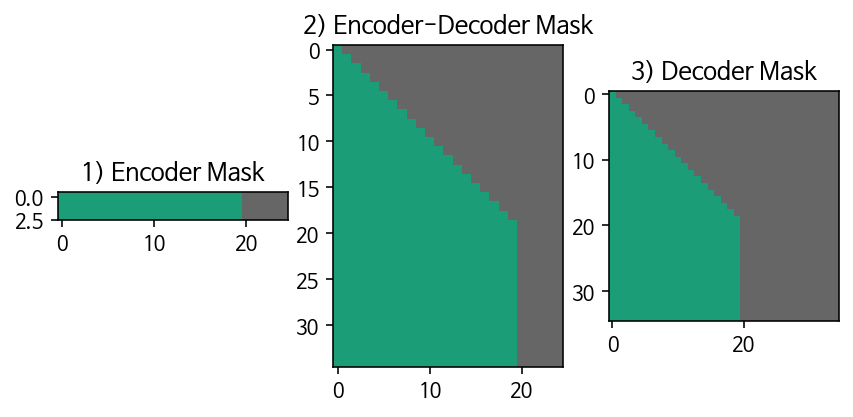

In [12]:
import matplotlib.pyplot as plt

batch, length = 16, 20
src_padding = 5
tgt_padding = 15

src_pad = tf.zeros(shape=(batch, src_padding))
tgt_pad = tf.zeros(shape=(batch, tgt_padding))

sample_data = tf.ones(shape=(batch, length))

sample_src = tf.concat([sample_data, src_pad], axis=-1)
sample_tgt = tf.concat([sample_data, tgt_pad], axis=-1)

enc_mask, dec_enc_mask, dec_mask = \
generate_masks(sample_src, sample_tgt)

fig = plt.figure(figsize=(7, 7))

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.set_title('1) Encoder Mask')
ax2.set_title('2) Encoder-Decoder Mask')
ax3.set_title('3) Decoder Mask')

ax1.imshow(enc_mask[:3, 0, 0].numpy(), cmap='Dark2')
ax2.imshow(dec_enc_mask[0, 0].numpy(), cmap='Dark2')
ax3.imshow(dec_mask[0, 0].numpy(), cmap='Dark2')

plt.show()

첫 번째 마스크는 각 배치 별로 데이터의 꼬리 부분을 Masking 하는 형태임을 알 수 있습니다. 낯선 부분은 두 번째와 세 번째의 Decoder가 연관된 마스크인데... 이것이 바로 Causality Mask와 Padding Mask를 결합한 형태입니다! 자기 회귀적인 특성을 살리기 위해 Masked Multi-Head Attention에서 인과 관계 마스킹을 했던 것을 기억하시죠? 인과 관계를 가리는 것도 중요하지만 Decoder 역시 \<PAD> 토큰은 피해 가야 하기 때문에 이런 형태의 마스크가 사용된답니다!

또, 트랜스포머는 고정된 Learning Rate를 사용하지 않았었죠! 논문의 해당 부분을 Optimizer까지 포함하여 다시 한번 살펴봅시다. 이전 노드에서 Learning Rate를 numpy 로 간단히 구현을 했었는데, 이번엔 Tensorflow 상에서 잘 구동될 수 있도록 LearningRateSchedule 클래스를 상속받아 구현해보죠!

In [13]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

learning_rate = LearningRateScheduler(512)
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98, 
                                     epsilon=1e-9)

print("슝=3")

슝=3


트랜스포머가 제안한 수식이 아니더라도 가변적인 Learning Rate를 사용하려면 위와 같이 구현을 하시면 됩니다. Optimizer와 Scheduler를 연결하는 과정도 아주 간단하죠! Optimizer는 논문에 정의된 대로 Adam Optimizer를 사용하며 세부 파라미터도 동일하게 맞춰 줍니다.

# 10-5. 프로젝트: 더 멋진 번역기 만들기
라이브러리 버전을 확인해 봅니다.
사용할 라이브러리 버전을 둘러봅시다.

In [7]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

import re
import os
import io
import time
import random

import seaborn # Attention 시각화를 위해 필요!

print(tf.__version__)

2.6.0


## Step 1. 데이터 다운로드 (클라우드 유저용)
아래 링크에서 korean-english-park.train.tar.gz 를 사용할 예정입니다. 다운로드할 필요는 없습니다.

[jungyeul/korean-parallel-corpora](https://github.com/jungyeul/korean-parallel-corpora/tree/master/korean-english-news-v1)

☁️클라우드 환경에서는 위 데이터를 미리 준비해 놓았으니 연결만 시켜줍시다. 우측 하단의 Cloud shell을 열어주세요.
아래와 같이 공유 디렉토리에 저장된 데이터를 가리키는 심볼릭 링크를 생성해 주시면 됩니다.
```
$ ln -s ~/data ~/aiffel/transformer/data
```

## Step 2. 데이터 정제 및 토큰화
set 데이터형이 중복을 허용하지 않는다는 것을 활용해 중복된 데이터를 제거하도록 합니다. 데이터의 병렬 쌍이 흐트러지지 않게 주의하세요! 중복을 제거한 데이터를 cleaned_corpus 에 저장합니다.

In [9]:
data_dir = os.getenv('HOME')+'/aiffel/transformer/data' # data folder path
kor_path = data_dir+"/korean-english-park.train.ko" # kor_corpus data name
eng_path = data_dir+"/korean-english-park.train.en" # eng_corpus data name

# 데이터 정제 및 토큰화
def clean_corpus(kor_path, eng_path): # clean_corpus func declaration
    with open(kor_path, "r") as f: kor = f.read().splitlines()     # open kor_corpus and split all line entities into list
    with open(eng_path, "r") as f: eng = f.read().splitlines()     # open eng_corpus and split all line entities into list
    assert len(kor) == len(eng)   # assert whether kor and eng list lengths are same

    # [[YOUR CODE]]
    cleaned_corpus = pd.DataFrame([kor, eng], index=['kor', 'eng']).T
    
    cleaned_corpus.drop_duplicates(inplace=True)
    cleaned_corpus.dropna(how='any', inplace=True)
    cleaned_corpus.reset_index(drop=True)

    return cleaned_corpus

cleaned_corpus = clean_corpus(kor_path, eng_path)

In [11]:
cleaned_corpus.head()

,kor,eng
0,"개인용 컴퓨터 사용의 상당 부분은 ""이것보다 뛰어날 수 있느냐?""","Much of personal computing is about ""can you t..."
1,모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하...,so a mention a few weeks ago about a rechargea...
2,그러나 이것은 또한 책상도 필요로 하지 않는다.,"Like all optical mice, But it also doesn't nee..."
3,"79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분...",uses gyroscopic sensors to control the cursor ...
4,정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔...,Intelligence officials have revealed a spate o...


정제 함수를 아래 조건을 만족하게 정의하세요.

- 모든 입력을 소문자로 변환합니다.
- 알파벳, 문장부호, 한글만 남기고 모두 제거합니다.
- 문장부호 양옆에 공백을 추가합니다.
- 문장 앞뒤의 불필요한 공백을 제거합니다.

In [10]:
def preprocess_sentence(sentence, s_token=False, e_token=False):
    sentence = sentence.lower().strip()

    sentence = re.sub(r"['¡°¡¦¡¯¡±]", "", sentence) 
    sentence = re.sub(r"([#*+-/:;<=>@\[\]\"^_`{|}~])", "", sentence)
    sentence = re.sub(r"([$%&()?!',.])", r" \1 ", sentence) 
    sentence = re.sub(r"[' ']+", " ", sentence)


    if s_token:
        sentence = '<start> ' + sentence

    if e_token:
        sentence += ' <end>'
    
    return sentence

한글 말뭉치 kor_corpus 와 영문 말뭉치 eng_corpus 를 각각 분리한 후, 정제하여 토큰화를 진행합니다! 토큰화에는 Sentencepiece를 활용하세요. 첨부된 공식 사이트를 참고해 아래 조건을 만족하는 generate_tokenizer() 함수를 정의합니다. 최종적으로 ko_tokenizer 과 en_tokenizer 를 얻으세요. en_tokenizer에는 set_encode_extra_options("bos:eos") 함수를 실행해 타겟 입력이 문장의 시작 토큰과 끝 토큰을 포함할 수 있게 합니다.

- [google/sentencepiece](https://github.com/google/sentencepiece)


- 단어 사전을 매개변수로 받아 원하는 크기의 사전을 정의할 수 있게 합니다. (기본: 20,000)
- 학습 후 저장된 model 파일을 SentencePieceProcessor() 클래스에 Load()한 후 반환합니다.
- 특수 토큰의 인덱스를 아래와 동일하게 지정합니다.
<PAD> : 0 / <BOS> : 1 / <EOS> : 2 / <UNK> : 3

In [45]:

eng_corpus = []
kor_corpus = []

Row_list =[]
  
# Iterate over each row
for index, rows in cleaned_corpus.iterrows():
    # Create list for the current row
    my_list =[rows.kor, rows.eng]
      
    # append the list to the final list
    Row_list.append(my_list)

In [53]:
rse, abc = Row_list[0]

In [54]:
rse

'개인용 컴퓨터 사용의 상당 부분은 이것보다 뛰어날 수 있느냐 ? '

In [55]:
abc

'much of personal computing is about can you top this ? '

In [67]:
# Sentencepiece를 활용하여 학습한 tokenizer를 생성합니다.
def generate_tokenizer(corpus,
                        vocab_size,
                        lang="ko",
                        pad_id=0,
                        bos_id=1,
                        eos_id=2,
                        unk_id=3):
    # [[YOUR CODE]]
    temp_file = f'./train.{lang}.temp'



    with open(temp_file, 'w') as f:
        for row in corpus:
            f.write(str(row) + '\n')

    spm.SentencePieceTrainer.Train(
    '--input={} \
     --model_prefix=temp_spm \
     --vocab_size={} \
     --pad_id={} \
     --bos_id={} \
     --eos_id={} \
     --unk_id={}'.format(
        temp_file, 
        vocab_size, 
        pad_id, 
        bos_id, 
        eos_id, 
        unk_id)    
    )
    s = spm.SentencePieceProcessor()
    s.Load('temp_spm.model')

    return s



SRC_VOCAB_SIZE = TGT_VOCAB_SIZE = 14178

eng_corpus = []
kor_corpus = []

Row_list =[]
  
# Iterate over each row
for index, rows in cleaned_corpus.iterrows():
    # Create list for the current row
    my_list =[rows.kor, rows.eng]
      
    # append the list to the final list
    Row_list.append(my_list)

for pair in Row_list:
    k, e = pair

    kor_corpus.append(preprocess_sentence(k))
    eng_corpus.append(preprocess_sentence(e))
    
    
ko_tokenizer = generate_tokenizer(kor_corpus, SRC_VOCAB_SIZE, "ko")
en_tokenizer = generate_tokenizer(eng_corpus, TGT_VOCAB_SIZE, "en")
en_tokenizer.set_encode_extra_options("bos:eos")

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=./train.ko.temp      --model_prefix=temp_spm      --vocab_size=14178      --pad_id=0      --bos_id=1      --eos_id=2      --unk_id=3
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: ./train.ko.temp
  input_format: 
  model_prefix: temp_spm
  model_type: UNIGRAM
  vocab_size: 14178
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 3
  bos_id: 1
  eos_id: 2
  

True

토크나이저를 활용해 토큰의 길이가 50 이하인 데이터를 선별하여 src_corpus 와 tgt_corpus 를 각각 구축하고, 텐서 enc_train 과 dec_train 으로 변환하세요! (❗모든 데이터를 사용할 경우 학습에 굉장히 오랜 시간이 걸립니다.)

In [38]:
for i in range(5):
    print(">> ", kor_corpus[i])
    print(">> ", eng_corpus[i])
    print()


>>  개인용 컴퓨터 사용의 상당 부분은 이것보다 뛰어날 수 있느냐 ? 
>>  much of personal computing is about can you top this ? 

>>  모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하지 않는다
>>  so a mention a few weeks ago about a rechargeable wireless optical mouse brought in another rechargeable wireless mouse

>>  그러나 이것은 또한 책상도 필요로 하지 않는다
>>  like all optical mice but it also doesnt need a desk

>>  7995달러하는 이 최첨단 무선 광마우스는 허공에서 팔목 팔 그외에 어떤 부분이든 그 움직임에따라 커서의 움직임을 조절하는 회전 운동 센서를 사용하고 있다
>>  uses gyroscopic sensors to control the cursor movement as you move your wrist arm whatever through the air

>>  정보 관리들은 동남 아시아에서의 선박들에 대한 많은 ( 테러 ) 계획들이 실패로 돌아갔음을 밝혔으며 세계 해상 교역량의 거의 3분의 1을 운송하는 좁은 해로인 말라카 해협이 테러 공격을 당하기 쉽다고 경고하고 있다
>>  intelligence officials have revealed a spate of foiled plots on ships in southeast asia and are warning that a narrow stretch of water carrying almost one third of the worlds maritime trade is vulnerable to a terror attack



In [69]:
en_tokenizer

<sentencepiece.SentencePieceProcessor; proxy of <Swig Object of type 'sentencepiece::SentencePieceProcessor *' at 0x7f501605f600> >

In [68]:
from tqdm.notebook import tqdm    # Process 과정을 보기 위해

src_corpus = []
tgt_corpus = []

assert len(kor_corpus) == len(eng_corpus)

# 토큰의 길이가 50 이하인 문장만 남깁니다. 
for idx in tqdm(range(len(kor_corpus))):
    tokensko = ko_tokenizer.EncodeAsIds(kor_corpus[idx])
    tokensen = en_tokenizer.EncodeAsIds(eng_corpus[idx])
    
    if 3 < len(tokensko) < 50 and 6 < len(tokensen) < 50:
        src_corpus.append(tokensko)
        tgt_corpus.append(tokensen)

# 패딩처리를 완료하여 학습용 데이터를 완성합니다. 
enc_train = tf.keras.preprocessing.sequence.pad_sequences(src_corpus, padding='post')
dec_train = tf.keras.preprocessing.sequence.pad_sequences(tgt_corpus, padding='post')

  0%|          | 0/10632 [00:00<?, ?it/s]

## Step 3. 모델 설계
오늘 배운 내용을 활용해서 Transformer 모델을 설계해보세요!


1. 입력 데이터 → [ batch_size x length ]
2. Source & Target Embedding → [ batch_size x length x d_emb ]
3. Positional Encoding 강의 노드에서 구현을 했었죠? 2번의 결과에 더해지므로 shape 변화는 없습니다.
4. Multi-Head Attention 아래와 같이 여러 개의 서브 모듈들이 존재합니다.
    1. Split Heads →[ batch_size x length x heads x (d_emb / n_heads) ]
    2. Masking for Masked Attention
    3. Scaled Dot Product Attention
    4. Combine Heads →[ batch_size x length x d_emb ]
5. Residual Connection
6. Layer Normalization
7. Position-wise Feed-Forward Network → [ batch_size x length x d_ff ]
8. Output Linear Layer → [ batch_size x length x vocab_size ]

### positional_encoding

In [70]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    return sinusoid_table

### Multi head attention

In [71]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
            
        self.depth = d_model // self.num_heads
            
        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
            
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)  

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions
            

    def split_heads(self, x):
        batch_size = x.shape[0]
        split_x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        batch_size = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (batch_size, -1, self.d_model))

        return combined_x

        
    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
            
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)
    				        
        out = self.combine_heads(out)
        out = self.linear(out)
                
        return out, attention_weights

### positon-wise FFN

In [73]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)
            
        return out

### Encoder layer

In [75]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):

        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual
        
        return out, enc_attn

### Decoder layer

In [76]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, enc_out, causality_mask, padding_mask):

        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.dropout(out)
        out += residual

        """
        Multi-Head Attention
        """
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, causality_mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual

        return out, dec_attn, dec_enc_attn

### Encoder

In [78]:
class Encoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

### Decoder

In [80]:
class Decoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
                            
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

### Transformer

In [96]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared=True):
        super(Transformer, self).__init__()
        self.units = d_model
        self.n_heads = n_heads
        self.d_ff = d_ff
        self.drop = dropout
        self.d_model = tf.cast(d_model, tf.float32)

        self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.dropout = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared = shared

        if shared: self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]
        out = emb(x)

        if self.shared: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.dropout(out)

        return out

        
    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, causality_mask, dec_mask)
        
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns

### Masking

In [83]:
import numpy as np
import tensorflow as tf

def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask

### Padding mask

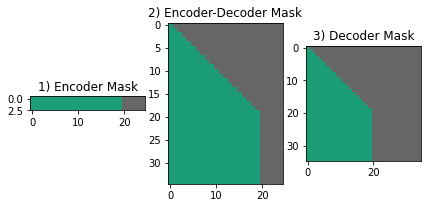

In [84]:
import matplotlib.pyplot as plt

batch, length = 16, 20
src_padding = 5
tgt_padding = 15

src_pad = tf.zeros(shape=(batch, src_padding))
tgt_pad = tf.zeros(shape=(batch, tgt_padding))

sample_data = tf.ones(shape=(batch, length))

sample_src = tf.concat([sample_data, src_pad], axis=-1)
sample_tgt = tf.concat([sample_data, tgt_pad], axis=-1)

enc_mask, dec_enc_mask, dec_mask = \
generate_masks(sample_src, sample_tgt)

fig = plt.figure(figsize=(7, 7))

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.set_title('1) Encoder Mask')
ax2.set_title('2) Encoder-Decoder Mask')
ax3.set_title('3) Decoder Mask')

ax1.imshow(enc_mask[:3, 0, 0].numpy(), cmap='Dark2')
ax2.imshow(dec_enc_mask[0, 0].numpy(), cmap='Dark2')
ax3.imshow(dec_mask[0, 0].numpy(), cmap='Dark2')

plt.show()

### 변화하는 Learning Rate

In [85]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

learning_rate = LearningRateScheduler(512)
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98, 
                                     epsilon=1e-9)

print("슝=3")

슝=3


## Step 4. 훈련하기
앞서 필요한 것들을 모두 정의했기 때문에 우리는 훈련만 하면 됩니다! 아래 과정을 차근차근 따라가며 모델을 훈련하고, 예문에 대한 멋진 번역을 제출하세요!

- 2 Layer를 가지는 Transformer를 선언하세요.
(하이퍼파라미터는 자유롭게 조절합니다.)

In [86]:

transformer = Transformer(
    n_layers = 2,
    d_model = 512,
    n_heads = 8,
    d_ff = 2048,
    src_vocab_size = SRC_VOCAB_SIZE,
    tgt_vocab_size = TGT_VOCAB_SIZE,
    pos_len = 50,
    dropout = 0.2,
    shared = True
)

논문에서 사용한 것과 동일한 Learning Rate Scheduler를 선언하고, 이를 포함하는 Adam Optimizer를 선언하세요. (Optimizer의 파라미터 역시 논문과 동일하게 설정합니다.)

In [87]:
learning_rate = LearningRateScheduler(512)
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98, 
                                     epsilon=1e-9)

Loss 함수를 정의하세요.
Sequence-to-sequence 모델에서 사용했던 Loss와 유사하되, Masking 되지 않은 입력의 개수로 Scaling하는 과정을 추가합니다. (트랜스포머가 모든 입력에 대한 Loss를 한 번에 구하기 때문입니다.)

In [88]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    # Masking 되지 않은 입력의 개수로 Scaling하는 과정
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

train_step 함수를 정의하세요.
입력 데이터에 알맞은 Mask를 생성하고, 이를 모델에 전달하여 연산에서 사용할 수 있게 합니다.

In [89]:
# Train Step 함수 정의

@tf.function()
def train_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]
        
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    # 계산된 loss에 tf.GradientTape()를 적용해 학습을 진행합니다.
    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions[:, :-1])

    # 최종적으로 optimizer.apply_gradients()가 사용됩니다. 
    batch_loss = (loss / int(tgt.shape[1]))

    variables = model.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return loss, enc_attns, dec_attns, dec_enc_attns

학습을 진행합니다.
매 Epoch 마다 제시된 예문에 대한 번역을 생성하고, 멋진 번역이 생성되면 그때의 하이퍼파라미터와 생성된 번역을 제출하세요!

예문
```
1. 오바마는 대통령이다.
2. 시민들은 도시 속에 산다.
3. 커피는 필요 없다.
4. 일곱 명의 사망자가 발생했다.
```
결과(output)
```
Translations
> 1. obama is the president elect .
> 2. they are in the city .
> 3. they don t need to be a lot of drink .
> 4. seven other people have been killed in the attacks .

Hyperparameters
> n_layers: 2
> d_model: 512
> n_heads: 8
> d_ff: 2048
> dropout: 0.3

Training Parameters
> Warmup Steps: 4000
> Batch Size: 64
> Epoch At: 5
```

번역 생성에는 아래 소스를 사용하시길 바랍니다!

In [90]:
# Attention 시각화 함수

def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    def draw(data, ax, x="auto", y="auto"):
        import seaborn
        seaborn.heatmap(data, 
                        square=True,
                        vmin=0.0, vmax=1.0, 
                        cbar=False, ax=ax,
                        xticklabels=x,
                        yticklabels=y)
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Encoder Layer", layer + 1)
        for h in range(4):
            draw(enc_attns[layer][0, h, :len(src), :len(src)], axs[h], src, src)
        plt.show()
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Decoder Self Layer", layer+1)
        for h in range(4):
            draw(dec_attns[layer][0, h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
        plt.show()

        print("Decoder Src Layer", layer+1)
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        for h in range(4):
            draw(dec_enc_attns[layer][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
        plt.show()

In [91]:
# 번역 생성 함수

def evaluate(sentence, model, src_tokenizer, tgt_tokenizer):
    sentence = preprocess_sentence(sentence)

    pieces = src_tokenizer.encode_as_pieces(sentence)
    tokens = src_tokenizer.encode_as_ids(sentence)

    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')
    
    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(_input, output)

        predictions, enc_attns, dec_attns, dec_enc_attns =\
        model(_input, 
              output,
              enc_padding_mask,
              combined_mask,
              dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = tgt_tokenizer.decode_ids(ids)

    return pieces, result, enc_attns, dec_attns, dec_enc_attns

In [94]:
# 번역 생성 및 Attention 시각화 결합

def translate(sentence, model, src_tokenizer, tgt_tokenizer, plot_attention=False):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sentence, model, src_tokenizer, tgt_tokenizer)
    
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    if plot_attention:
        visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)
        

# def Hyperparameters(model, epoch):
#     print('Hyperparameters')
#     print('> n_layers :', model.encoder.n_layers)
#     print('> d_model :', model.units)
#     print('> n_heads :', model.n_heads)
#     print('> d_ff :', model.d_ff)
#     print('> dropout :', model.drop)
#     print()
    
#     print('Training Parameters')
#     print('> Warmup Steps :', learning_rate.warmup_steps)
#     print('> Batch Size :', BATCH_SIZE)
#     print('> Epoch At :', epoch)

translate() 함수의 plot_attention 변수를 True 로 주면 번역 결과에 대한 Attention Map을 시각화 해볼 수 있습니다.

마지막으로, 학습의 전 과정을 구현한 코드를 첨부합니다. 구현 과정에 참고해 주세요. 수고하셨습니다!!

In [98]:
from tqdm import tqdm_notebook 

BATCH_SIZE = 64
EPOCHS = 20

examples = [
            "오바마는 대통령이다.",
            "시민들은 도시 속에 산다.",
            "커피는 필요 없다.",
            "일곱 명의 사망자가 발생했다."
]

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm_notebook(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train[idx:idx+BATCH_SIZE],
                    dec_train[idx:idx+BATCH_SIZE],
                    transformer,
                    optimizer)

        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

    for example in examples:
        translate(example, transformer, ko_tokenizer, en_tokenizer)

/tmp/ipykernel_31/2719091706.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm_notebook(idx_list)


  0%|          | 0/151 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is no president bush and president bush
Input: 시민들은 도시 속에 산다.
Predicted translation: the sunally in the city of the big urban
Input: 커피는 필요 없다.
Predicted translation: no idea no longer
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the dead were dead


  0%|          | 0/151 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is great president obama is popular president president george president obama on president george president obama obama obama is popular vote obama on president obama obama on the president obama
Input: 시민들은 도시 속에 산다.
Predicted translation: in the city city city of the city
Input: 커피는 필요 없다.
Predicted translation: there is no immediate true for no matter
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: sevens of military began dead


  0%|          | 0/151 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is no president
Input: 시민들은 도시 속에 산다.
Predicted translation: for a year by the port city of the port city of ash measures
Input: 커피는 필요 없다.
Predicted translation: there is no need
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the sixyearold occurred dead dead


  0%|          | 0/151 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is no president bill clinton is no president bill clinton is no idea no idea no president bill clinton is no idea no idea
Input: 시민들은 도시 속에 산다.
Predicted translation: with a few restaurants and big urban
Input: 커피는 필요 없다.
Predicted translation: theres need to need a need
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll be dubbed dubbed the death toll began saturday


  0%|          | 0/151 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is covered president hes supported his president hes supported his president hes covered president hes covered president his president hes supported his president hes supported his president hes in his president hes going to president hes his president hes cover
Input: 시민들은 도시 속에 산다.
Predicted translation: ( cnn ) ethnic restaurants a port of conspiracy to childhood in childhood
Input: 커피는 필요 없다.
Predicted translation: there is true we cannot be true
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the victims of an dead dead dead dead


  0%|          | 0/151 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is no president hes said president hes hes said president hes no president bush obama hes not hes no pieces hes hes hes hes hes hes said obama earlier his obama hes hes hes said obama he said obama his obama is no white obama
Input: 시민들은 도시 속에 산다.
Predicted translation: heart time in the immediate lowering urbancal had been lowering and lowering urbancal taken to high behind the mountain mountains behind the mountain
Input: 커피는 필요 없다.
Predicted translation: hes a there is no over there is no over theres there are no over there a there over there is no there is no over there a no anyone and theres there
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll were killed the dead


  0%|          | 0/151 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama holds president bushs president bushs president bush
Input: 시민들은 도시 속에 산다.
Predicted translation: shook pompson had across the juni young heart city of heart city and heart mountain sleep well as city of city five heart city city in southern town
Input: 커피는 필요 없다.
Predicted translation: hes a no matter since no matter control
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven childrens dozens of gujarats left a crime is dead below the 16day crash


  0%|          | 0/151 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: speaking at israel is at israel president bush
Input: 시민들은 도시 속에 산다.
Predicted translation: south korea behind the municipal city of urban urbani porten and buildings in the urban urban port in the city of lower operations
Input: 커피는 필요 없다.
Predicted translation: hes a take further since 1998
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven car also had been dead


  0%|          | 0/151 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is no president bush in hes willing
Input: 시민들은 도시 속에 산다.
Predicted translation: in southern city cases have had a hugeen of r ( cnn ) of rs man in r castr aftermath of nearby mountains since the marinest problem of r urban border
Input: 커피는 필요 없다.
Predicted translation: like a microsoft dont need like a de there
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: six six six miles of six bangladeshs main seven six people dead and seven six kingdoms six kingdoms six terms


  0%|          | 0/151 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is no president obama is his obama campaign is no president obama obama campaign is no president obama obama obama campaign is no question
Input: 시민들은 도시 속에 산다.
Predicted translation: ex ) in nearly a lower of lower talks between the two and starts behind the two labor
Input: 커피는 필요 없다.
Predicted translation: hes just a combination that there is no need
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven were left more than 20 people were dead


  0%|          | 0/151 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is no idea great idea idea idea for president bush
Input: 시민들은 도시 속에 산다.
Predicted translation: the city by lowers filled with ( city of ideas
Input: 커피는 필요 없다.
Predicted translation: it was not immediately easy to reality and no longer
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the sun deaths occurred around 20000


  0%|          | 0/151 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: hes idea proitting president hes hes idea
Input: 시민들은 도시 속에 산다.
Predicted translation: ru struck by the city of flick
Input: 커피는 필요 없다.
Predicted translation: hes actually take away from theres need actually need to coffee actually need at bad television
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven were wounded


  0%|          | 0/151 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: tonight president hes in his president roh moohyun
Input: 시민들은 도시 속에 산다.
Predicted translation: ex )
Input: 커피는 필요 없다.
Predicted translation: it was a chain club
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the city needs more than 20 miles ( buildings ) a bomb had been turned dead to a land a needs by buildings


  0%|          | 0/151 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is no president obama president
Input: 시민들은 도시 속에 산다.
Predicted translation: ex ) the city of trails in all the elder
Input: 커피는 필요 없다.
Predicted translation: hes takes theres a long chain
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven childrens between us officials and people dead were at dead


  0%|          | 0/151 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: hes covered his president he said his solution president his means cleaner his president his presidents president hes willing his means his might hes formal against president his presidents president his presidents chavez
Input: 시민들은 도시 속에 산다.
Predicted translation: past month city are likely to sleep in several hundreds of sleeping by lower restaurants and thirdplace
Input: 커피는 필요 없다.
Predicted translation: hes just like a long credit
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven police have been arrested including hundreds of police chief victims of police chief was shot dead dead


  0%|          | 0/151 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: thanks to a south koreas official african president his ex pa his ex his his ex tears his ex tears his his ex pag his place
Input: 시민들은 도시 속에 산다.
Predicted translation: for all coalition of videos a live portents
Input: 커피는 필요 없다.
Predicted translation: like uss re impossible to take a few timess say that much bits do it
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the seven were thousands of the seven children have been official death dead since the seven


  0%|          | 0/151 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is his president bush against his president bush is his president obama his behavior
Input: 시민들은 도시 속에 산다.
Predicted translation: by all cities had one of the city of winning city of road and the city
Input: 커피는 필요 없다.
Predicted translation: hes just a bigger station
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the sevenrun china daily increased death toll could be arun news agency xinhua reported


  0%|          | 0/151 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: is true president he is his president
Input: 시민들은 도시 속에 산다.
Predicted translation: it was ( nearly impossible
Input: 커피는 필요 없다.
Predicted translation: hes just trying to have one in such a longtime program
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: six people believed a wounded in the latest case


  0%|          | 0/151 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president bush against president george w bush is seoul before
Input: 시민들은 도시 속에 산다.
Predicted translation: it is time in the city of impressi and several holes in the city of several smaller one of the two spring
Input: 커피는 필요 없다.
Predicted translation: hes not a further hess a further attack
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven0000 people occurred 39 deaths in the attack began at the site killed


  0%|          | 0/151 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president obama supported by president
Input: 시민들은 도시 속에 산다.
Predicted translation: it is time to take advantage of the situation
Input: 커피는 필요 없다.
Predicted translation: we have been a small amounts wrong
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven0000 were occurred intaken away


## 모델 학습 결과

Input: 오바마는 대통령이다.
Predicted translation: obama is the president obama supported by president
Encoder Layer 1


/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 50724 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 48148 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 47560 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 45716 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 45824 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 53685 missing from current font.
  font.set_

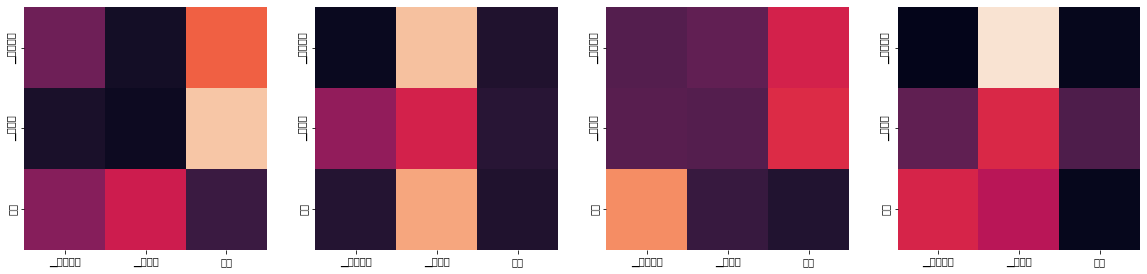

Encoder Layer 2


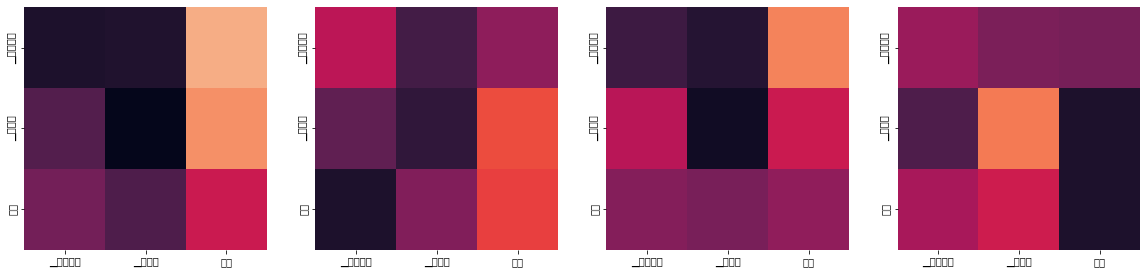

Decoder Self Layer 1


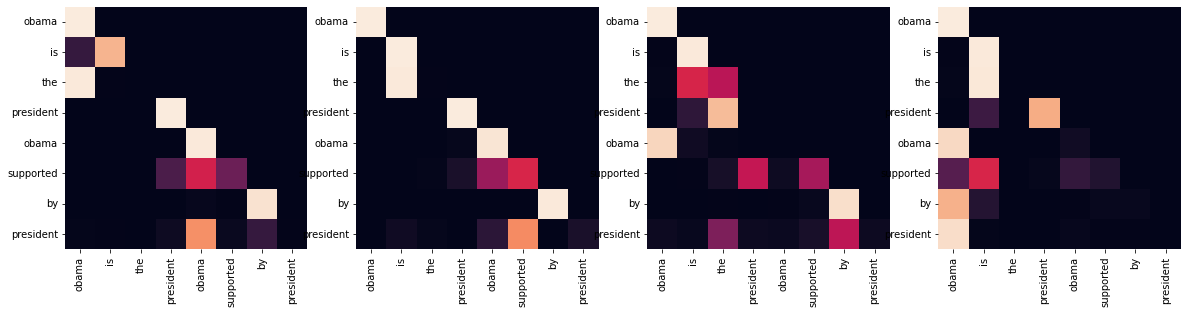

Decoder Src Layer 1


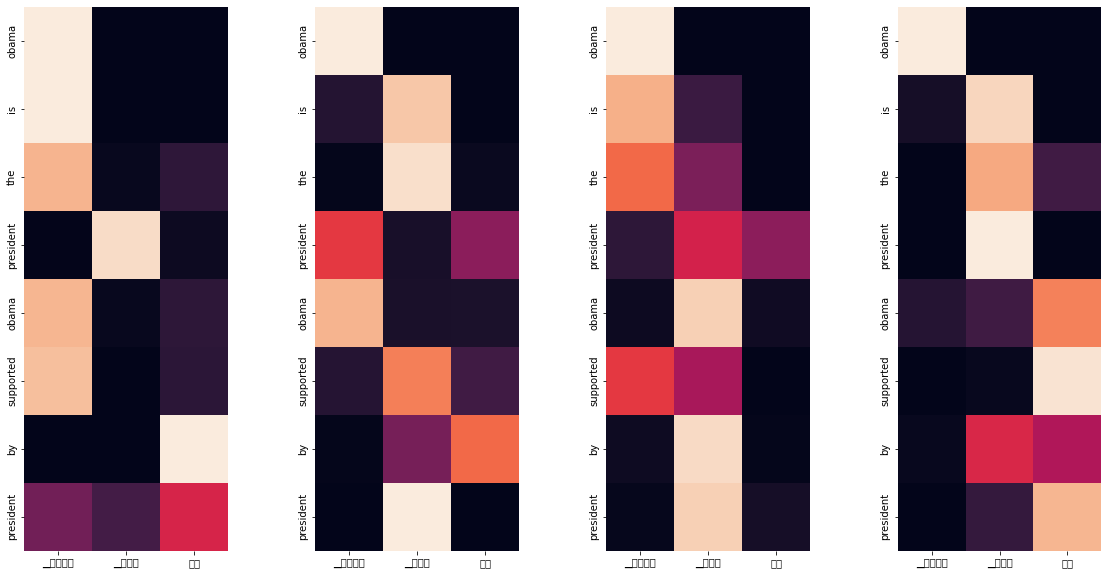

Decoder Self Layer 2


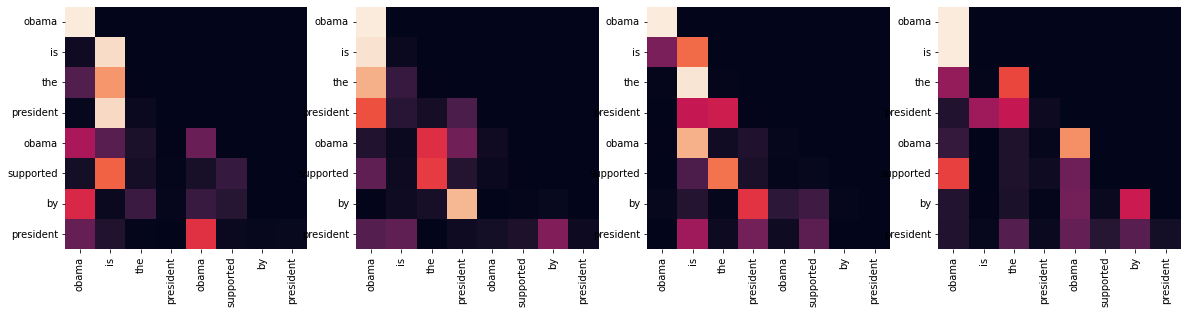

Decoder Src Layer 2


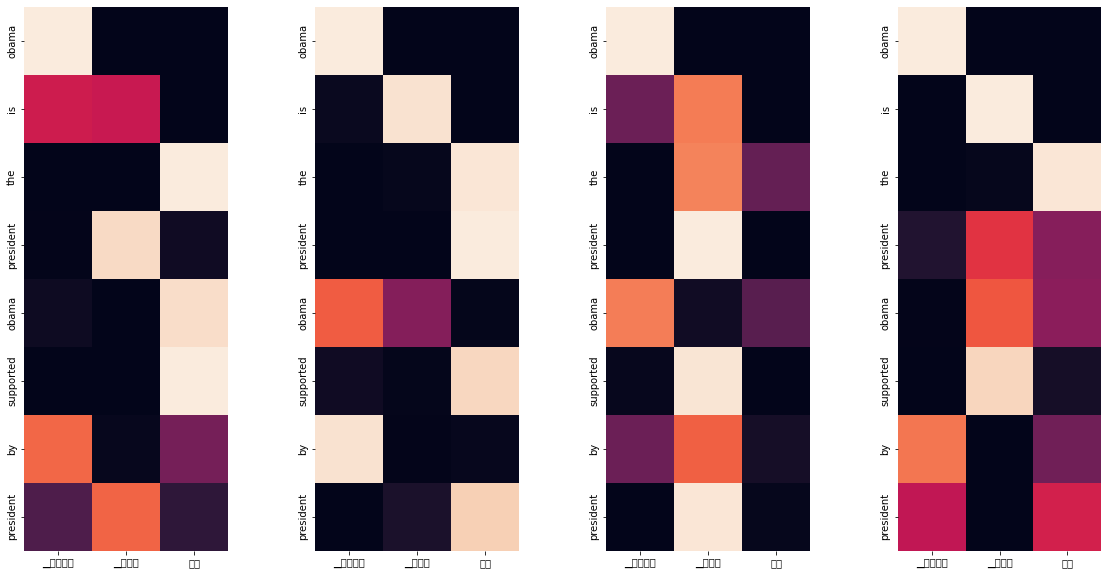

Input: 시민들은 도시 속에 산다.
Predicted translation: it is time to take advantage of the situation
Encoder Layer 1


/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 48124 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 46308 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 51008 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 49549 missing from current font.
  font.set_

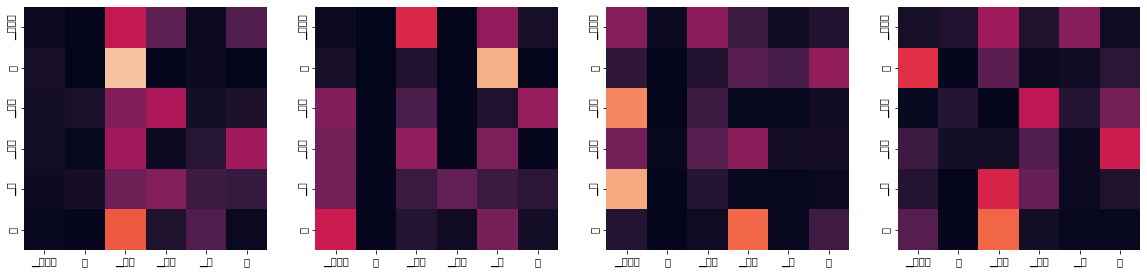

Encoder Layer 2


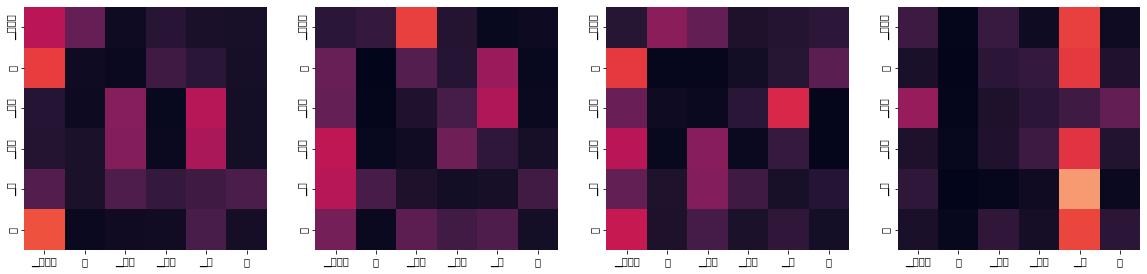

Decoder Self Layer 1


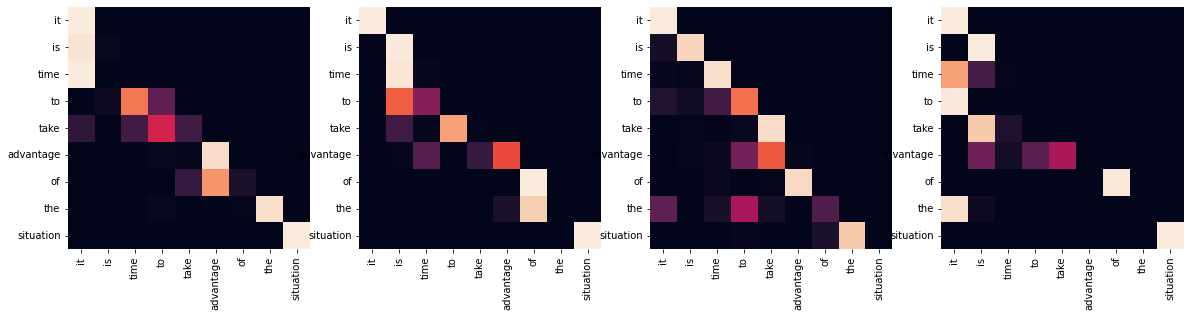

Decoder Src Layer 1


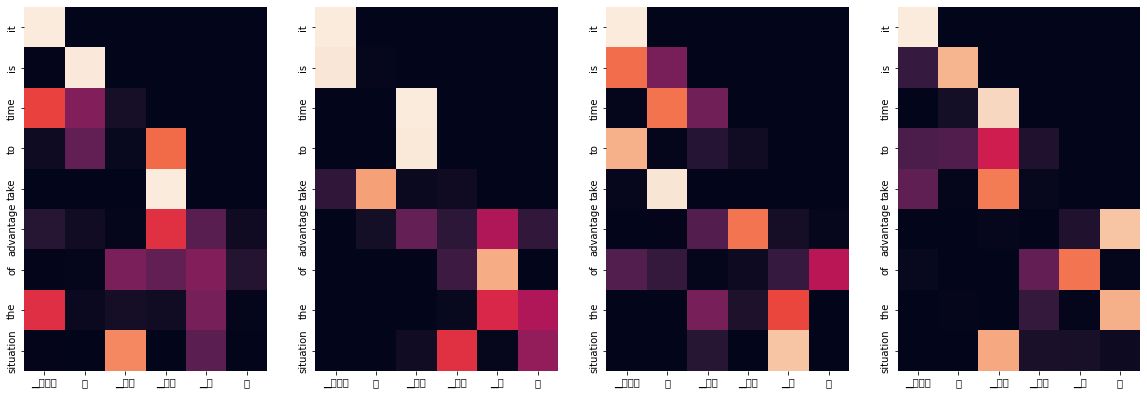

Decoder Self Layer 2


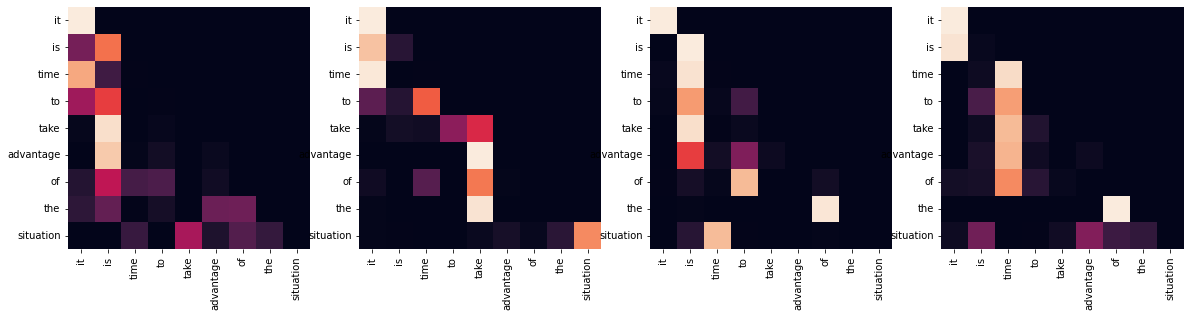

Decoder Src Layer 2


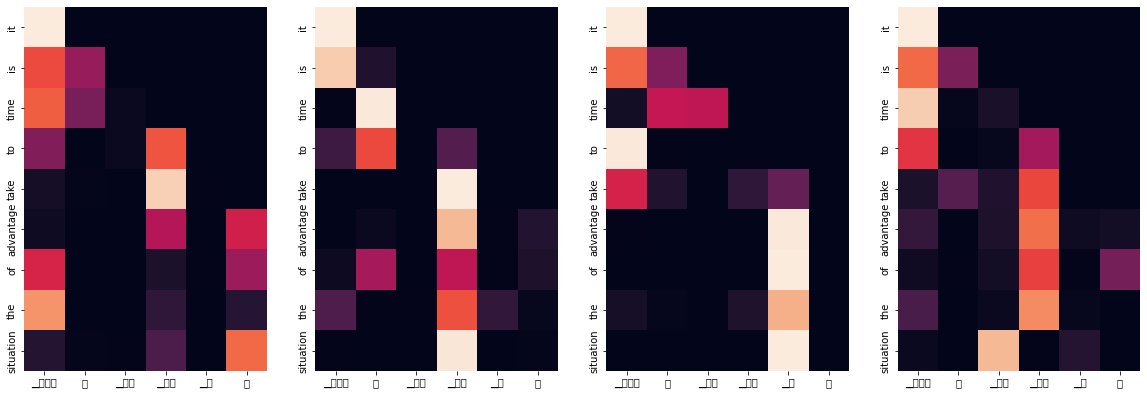

Input: 커피는 필요 없다.
Predicted translation: we have been a small amounts wrong
Encoder Layer 1


/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 52964 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 54588 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 54596 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 50836 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 50630 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 52964 missing from current font.
  font.set_

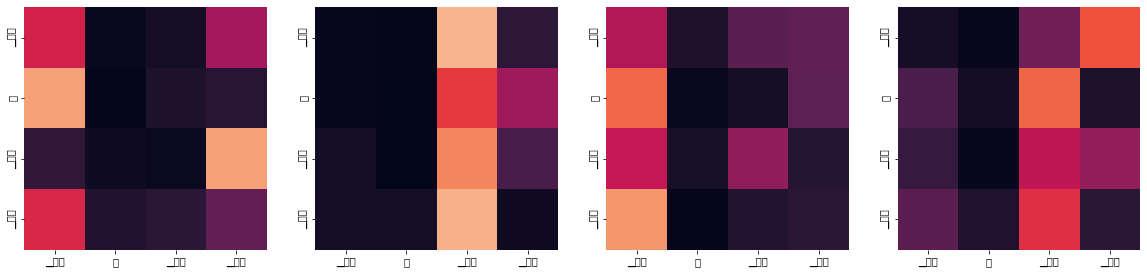

Encoder Layer 2


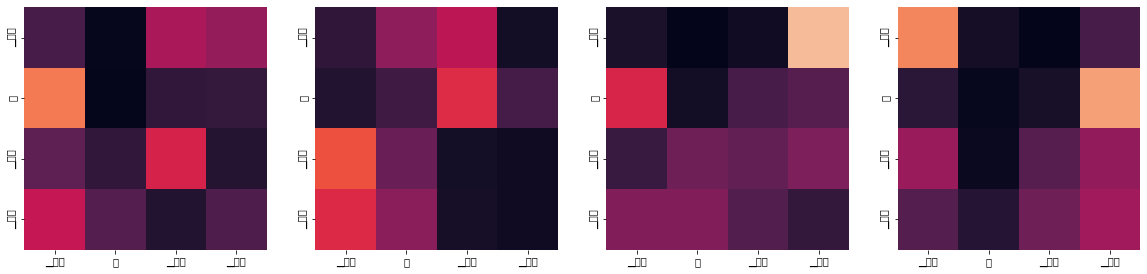

Decoder Self Layer 1


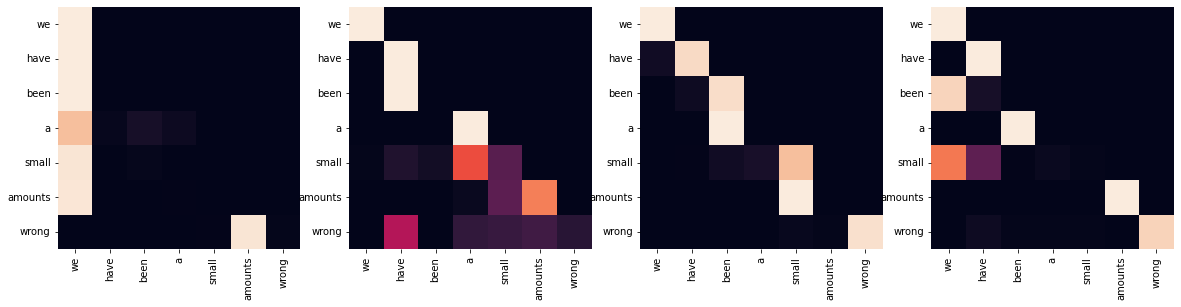

Decoder Src Layer 1


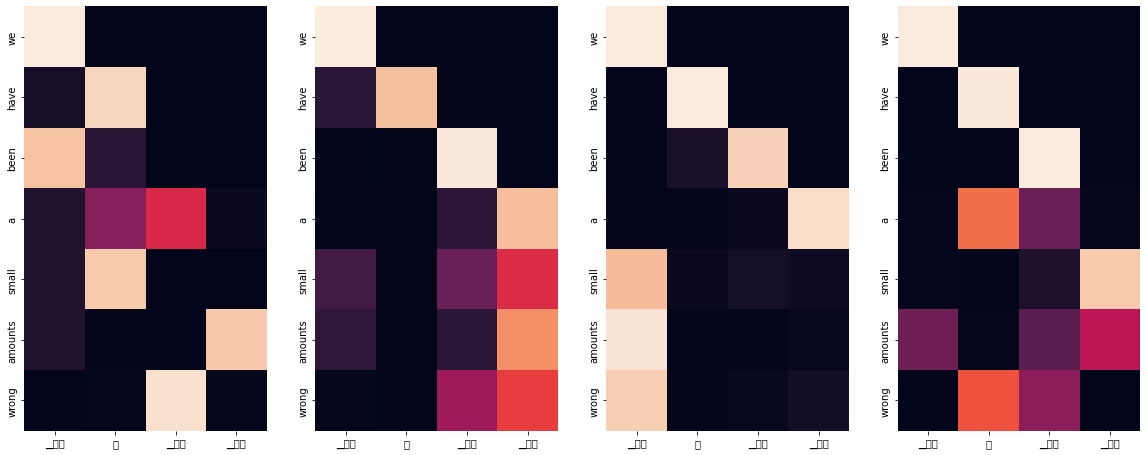

Decoder Self Layer 2


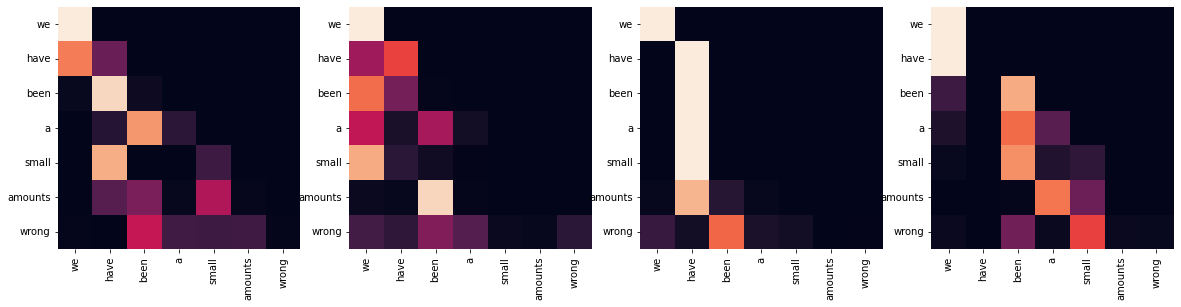

Decoder Src Layer 2


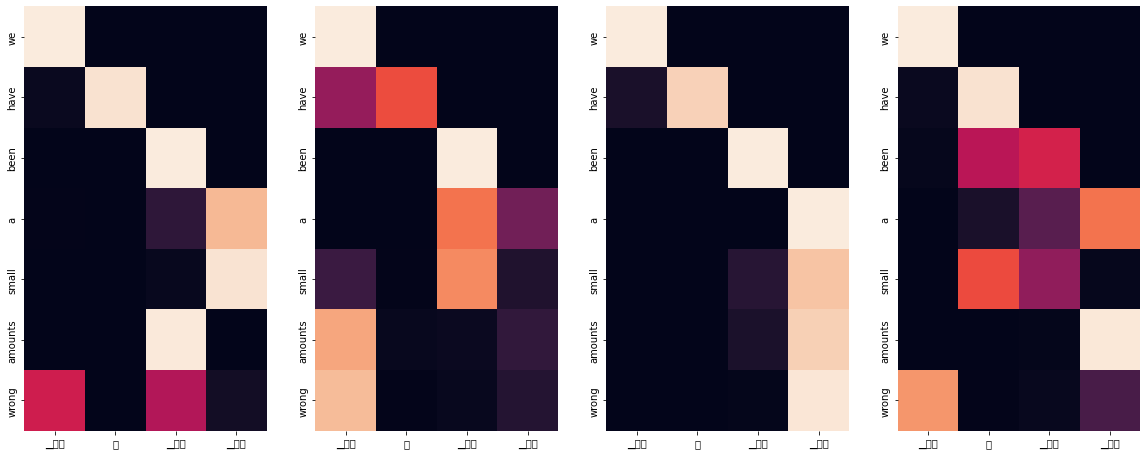

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven0000 were occurred intaken away
Encoder Layer 1


/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 51068 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 44273 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 47749 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 51032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 49324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 47581 missing from current font.
  font.set_

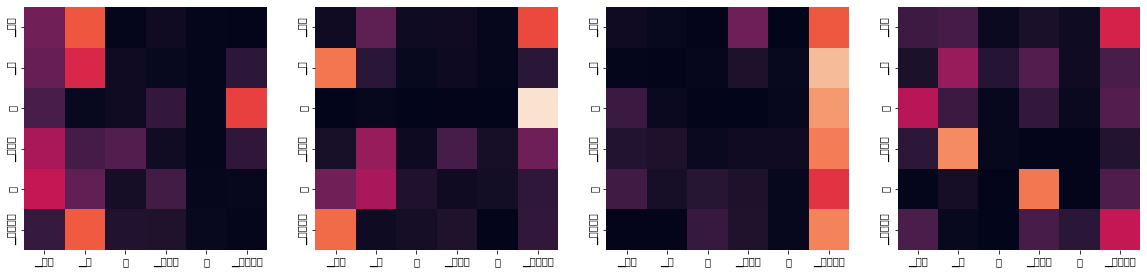

Encoder Layer 2


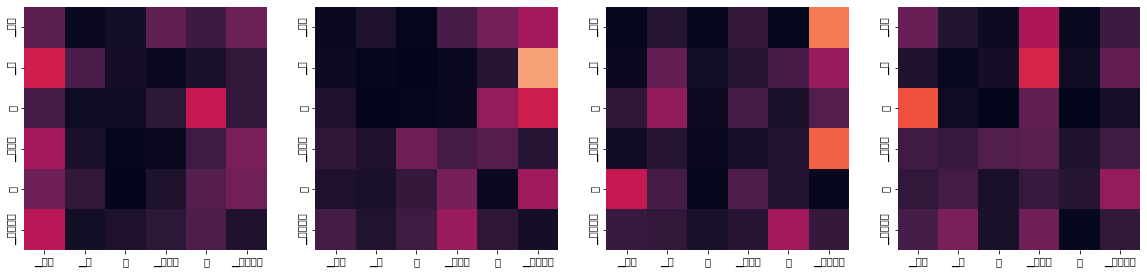

Decoder Self Layer 1


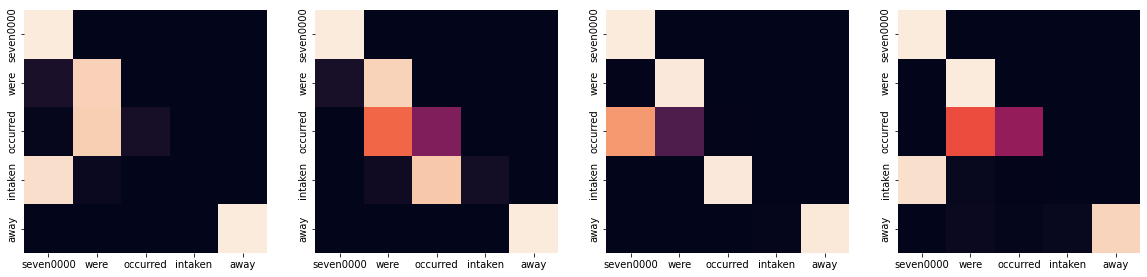

Decoder Src Layer 1


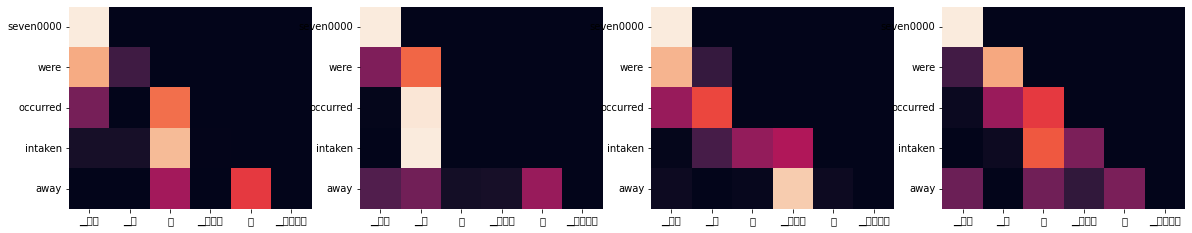

Decoder Self Layer 2


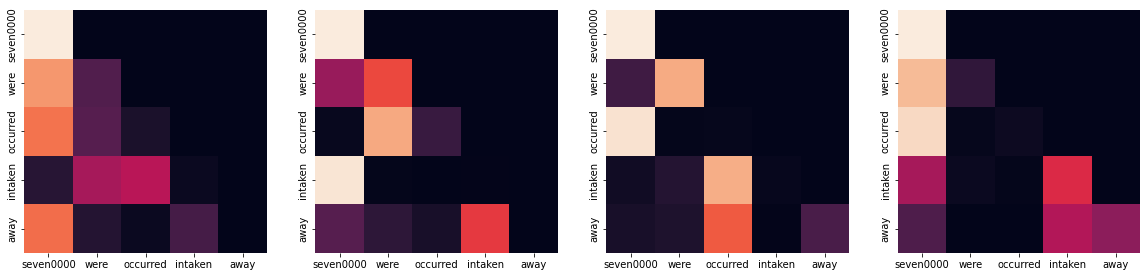

Decoder Src Layer 2


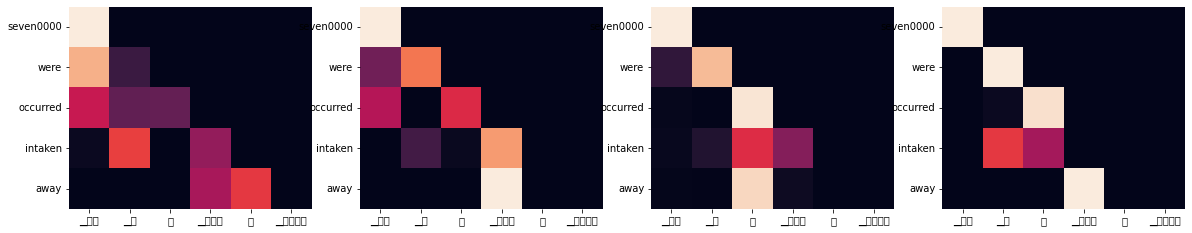

In [99]:
for example in examples:
    translate(example, transformer, ko_tokenizer, en_tokenizer, plot_attention=True)

# 회고

## 과정상의 어려움
- 트랜스포머의 구성요소들의 코드를 하나하나 작성하면서 실습을 진행하니 조금 이해가 되는 듯하다.
- 하지만 여전히 전부 이해하고 넘어가기에는 시간이 부족하다.
    - 인코더 디코더 구성이라던가
    - 센텐스피스 토크나이져 작동방법에 대해 좀 더 정리해봐야겠다.

## 결과
4개의 번역을 해본 결과 1개 정도 비슷하다고 할 수 있고 나머지는 다 이상하게 번역되었다.

    Input: 오바마는 대통령이다.
    Predicted translation: obama is the president obama supported by president
    오바마는 대통령에게 지원받은 오바마 대통령이다.

    Input: 시민들은 도시 속에 산다.
    Predicted translation: it is time to take advantage of the situation
    상황의 이점을 누릴 시간이다.

    Input: 커피는 필요 없다.
    Predicted translation: we have been a small amounts wrong
    우리는 아주 조금 잘못했다.

    Input: 일곱 명의 사망자가 발생했다.
    Predicted translation: seven0000 were occurred intaken away
    '7'0000명이 발생했습니다 \[이상한 말\]

이유를 정확하게 알 순없지만 그래도 하나는 제대로 된것이 다행이라고 해야할까?